In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining all constants

KAPPA = 20.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 233
N_DEFAULT = 43 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/1500
GAMMA_MEAS = 1/140
INIT_FID = 1 - 1e-4
SNR_SCALE = 1.9
STATE_STD = 1/jnp.sqrt(2)

In [4]:
def SS_meas_pF(
    amp, 
    ts
):
    '''
    Where amp is defined to take values between 0 and 1 like with IBMQ convention
    and ts is a sufficiently large linspace
    returns pF_res with shape (AMPS, TS)
    '''
    amp = amp.reshape(-1, 1)
    ts = ts.reshape(1, -1)
    amp_max = 0.5 * jnp.sqrt(N_MAX * (KAPPA ** 2 + CHI ** 2))
    photon = N_MAX * amp**2
    amp *= amp_max
    separation = (4 * amp * SNR_SCALE / (KAPPA ** 2 + CHI ** 2) 
                  * (CHI * (1. - jnp.exp(-0.5 * KAPPA * ts)) - 0.5 * KAPPA * CHI * ts * jnp.exp(-0.5 * KAPPA * ts)))
    separation_fid = 0.5 * (1. + erf(separation / (2 * jnp.sqrt(2) * STATE_STD)))
    decay_fid = INIT_FID * jnp.exp(-( 
        (GAMMA_PHOTON * photon + GAMMA_MEAS) * ts 
        - 4 * GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-0.5 * KAPPA * ts)) 
        + GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-KAPPA * ts)) 
        )
    )
    pF_res = -jnp.log10(1. - separation_fid * decay_fid)
    max_fidelity = jnp.max(pF_res, axis=-1)
    ts = ts.reshape(-1)
    time_of_max = ts[jnp.argmax(pF_res, axis=-1)]
    return pF_res, max_fidelity, time_of_max

In [5]:
ts = jnp.linspace(0., 0.4, 401)
amp_linspace = jnp.linspace(0.1, 1.0, 46)

batched_pF_res, batched_max_fidelity, batched_times = SS_meas_pF(amp_linspace, ts)

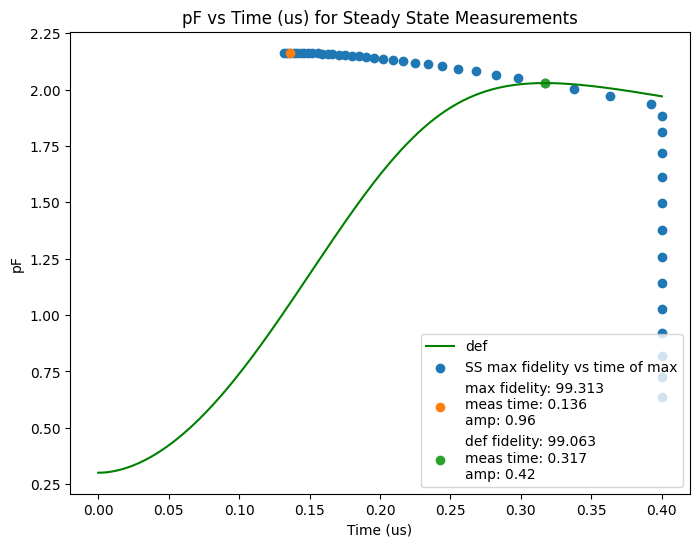

In [6]:
plt.figure(figsize=(8., 6.))
default_amp_ind = jnp.argmin(jnp.abs(amp_linspace - amp_default))
ss_fidelites = 1. - 10**(-batched_max_fidelity)

plt.plot(ts, batched_pF_res[default_amp_ind], label='def', color='green')
plt.scatter(batched_times, batched_max_fidelity, label='SS max fidelity vs time of max')
plt.scatter(
    batched_times[jnp.argmax(batched_max_fidelity)], 
    jnp.max(batched_max_fidelity), 
    label=f'max fidelity: {int(1e5*jnp.max(ss_fidelites)) / 1e3}\nmeas time: {int(1e3*batched_times[jnp.argmax(batched_max_fidelity)]) / 1e3}\namp: {int(1e3*amp_linspace[jnp.argmax(batched_max_fidelity)])/1e3}')
plt.scatter(
    batched_times[default_amp_ind], 
    batched_max_fidelity[default_amp_ind], 
    label=f'def fidelity: {int(1e5*jnp.max(ss_fidelites[default_amp_ind])) / 1e3}\nmeas time: {int(1e3*batched_times[default_amp_ind]) / 1e3}\namp: {int(1e3*amp_linspace[default_amp_ind])/1e3}')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('pF vs Time (us) for Steady State Measurements')
plt.legend()
plt.show()

In [13]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [14]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 2000 Updates
global update: 100
mean batch reward: [-53.32947221 -52.88402733 -51.80237391 -52.72297531 -53.76948595
 -51.97345201 -51.98977179 -53.90647634]
mean batch pF: [2.56577    2.56579828 2.56576725 2.56562508 2.56582631 2.56586989
 2.5658759  2.56589084]
mean batch photon: [66.50730896 66.5663147  66.2197876  66.47328186 66.63707733 66.28842163
 66.04888916 66.57556915]
mean batch photon time: [0.60678369 0.60726593 0.60381335 0.60510938 0.60717379 0.60573625
 0.60503922 0.6072576 ]
mean batch smoothness: [0.00279617 0.00264062 0.0028778  0.00225256 0.00279669 0.00242033
 0.00219432 0.00279432]
max reward obtained: [22.94019703 22.88971459 22.85509987 22.97796026 22.92362121 22.91663408
 22.90945651 22.939384  ]
pF at max: [2.55693574 2.56557887 2.56048111 2.55612936 2.55874236 2.56210524
 2.55605651 2.56612827]
photon at max: [31.80140114 36.60712433 33.59760284 30.42869377 33.61616516 34.39009094
 31.22503853 40.34064865]
photon time of max: [0.29518704 0.3

In [15]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
max_smoothness = metrics["smoothness at max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
mean_smoothness = metrics["mean batch smoothness"]
std_reward = metrics["std batch reward"]

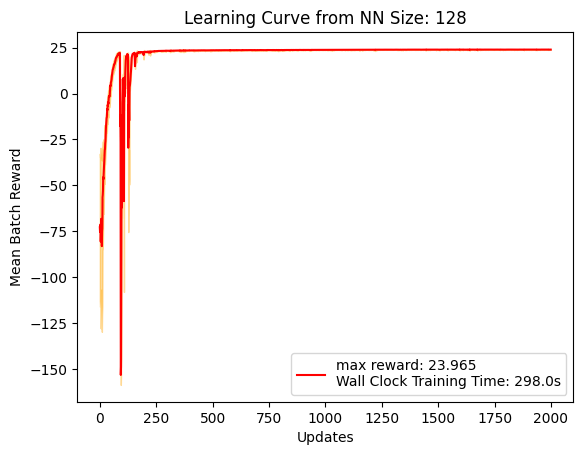

In [21]:
env_ind = 0
update_plot = 2000

x = np.arange(update_plot) # / update_plot * (end - start)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label=f'max reward: {int(1e3 * max_rewards[-1,0]) / 1e3}\nWall Clock Training Time: {int(1e1 *(end - start)) / 1e1}s', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Mean Batch Reward')
plt.title(f'Learning Curve from NN Size: {config["LAYER_SIZE"]}')
plt.show()

(2000, 8, 121)
0.05666666666666668
0.29518704427133363
0.17500000000000004


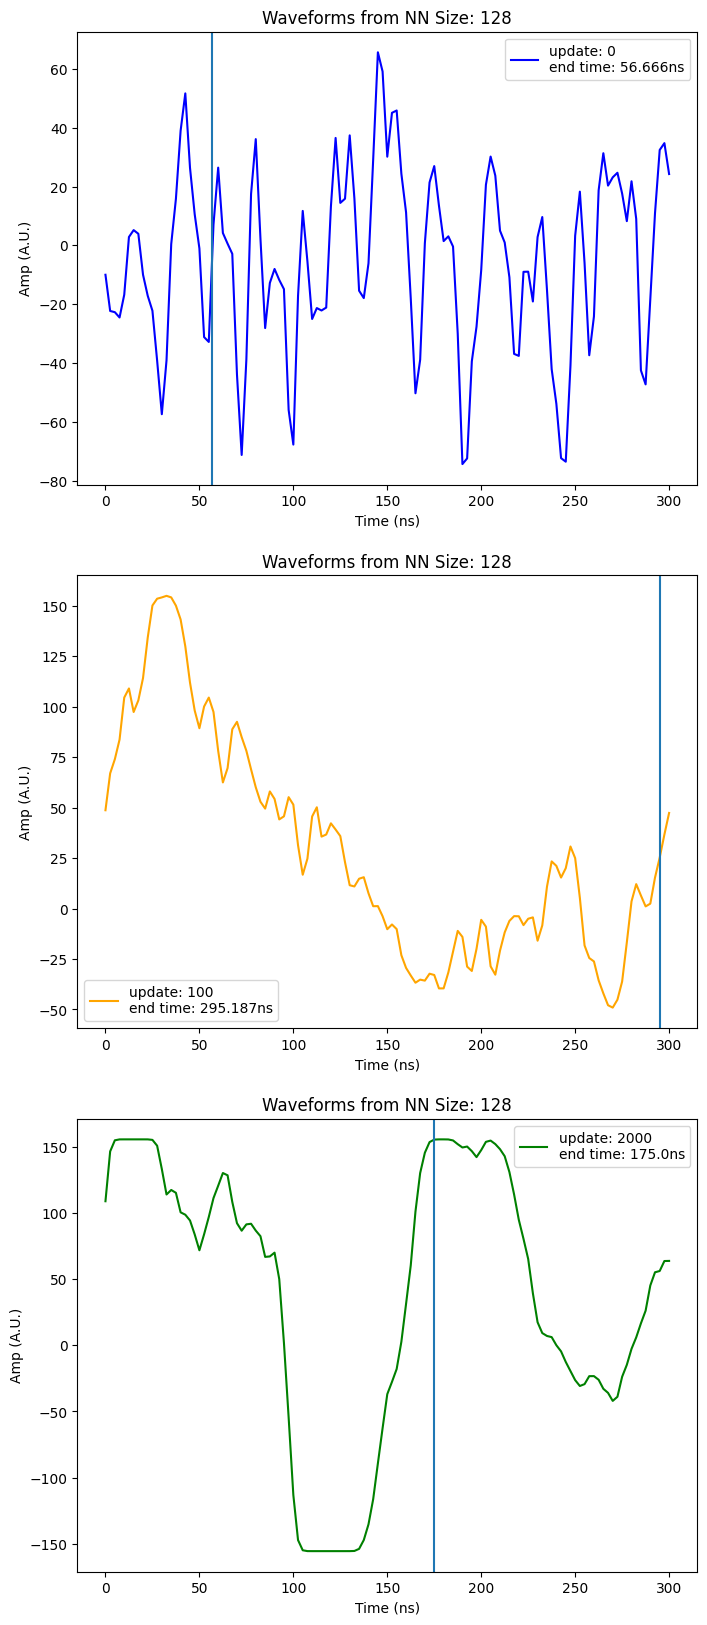

In [20]:
# Visualising Waveform Learning

plotting_updates = np.array([0, 100, 2000], dtype=np.int16)

print(max_actions.shape)

update_action = -max_actions[plotting_updates, 0]
action_linspace = np.linspace(0., num_t1 / kappa, update_action.shape[-1])

fig, ax = plt.subplots(len(plotting_updates), figsize=(8.0, 20.0))

color_list = ["blue", "orange", "green"]

for ind, action in enumerate(update_action):
    ax[ind].plot(action_linspace * 1e3, action, label=f'update: {plotting_updates[ind]}\nend time: {int(1e6 * max_times[plotting_updates[ind], 0]) / 1e3}ns', color=color_list[ind])
    ax[ind].axvline(x=1e6 * max_times[plotting_updates[ind], 0] / 1e3)
    print(max_times[plotting_updates[ind], 0])
    ax[ind].legend()
    ax[ind].set_xlabel('Time (ns)')
    ax[ind].set_ylabel('Amp (A.U.)')
    ax[ind].set_title(f'Waveforms from NN Size: {config["LAYER_SIZE"]}')
plt.show()